In [1]:
import pandas as pd; pd.options.mode.chained_assignment = None
import numpy as np

# Built In Imports

from datetime import datetime
from glob import glob
import warnings
import IPython
import urllib
import zipfile
import pickle
import shutil
import string
import math
import tqdm
import time
import os
import gc
import re

# Visualization Imports

from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from PIL import Image
import matplotlib
import plotly
import PIL
import cv2

from pycocotools.coco import COCO

# Other Imports

from tqdm.notebook import tqdm

LABELCOLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("Spectral", 10)]
LABELCOLORSWOUTNOFINDING = LABELCOLORS[:8]+LABELCOLORS[9:]

In [2]:
coco = COCO('../../dataset/train.json')
train_df = pd.DataFrame()
image_ids = []
class_name = []
class_id = []
x_min = []
y_min = []
x_max = []
y_max = []
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

for image_id in coco.getImgIds():
    imageinfo = coco.loadImgs(image_id)[0]
    annids = coco.getAnnIds(imgIds=imageinfo['id'])
    anns = coco.loadAnns(annids)
    filename = imageinfo['file_name']

    for ann in anns:
        image_ids.append(filename)
        class_name.append(classes[ann['category_id']])
        class_id.append(ann['category_id'])
        x_min.append(float(ann['bbox'][0]))
        y_min.append(float(ann['bbox'][1]))
        x_max.append(float(ann['bbox'][0]) + float(ann['bbox'][2]))
        y_max.append(float(ann['bbox'][1]) + float(ann['bbox'][3]))

train_df['image_id'] = image_ids
train_df['class_name'] = class_name
train_df['class_id'] = class_id
train_df['xmin'] = x_min
train_df['ymin'] = y_min
train_df['xmax'] = x_max
train_df['ymax'] = y_max

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


In [3]:
img = cv2.imread(os.path.join('../../dataset/', train_df.iloc[993]['image_id']))
img.shape

(1024, 1024, 3)

In [4]:
fig = px.histogram(train_df.image_id.value_counts(),
                    log_y=True, color_discrete_sequence=['indianred'], opacity=0.7,
                    labels={"value":"Number of Annotations Per Image"},
                    title="<b>DISTRIBUTION OF # OF ANNOTATIONS PER IMAGE "
                    "<i><sub>(Log Scale for Y-Axis)</sub></i></b>",
                    )

fig.update_layout(showlegend=False, xaxis_title="<b>Number of Unique Images</b>", yaxis_title="<b>Count of All Object Annotations</b>",)

fig.show()

In [5]:
fig = px.histogram(train_df.groupby('image_id')["class_id"].unique().apply(lambda x: len(x)),
log_y=True, color_discrete_sequence=['skyblue'], opacity=0.7,
labels={"value":"Number of Unique class"},
title="<b>DISTRIBUTION OF # OF Unique Class PER IMAGE "
"<i><sub>(Log Scale for Y-Axis)</sub></i></b>",
)

fig.update_layout(showlegend=False,
xaxis_title="<b>Number of Unique CLASS</b>",
yaxis_title="<b>Count of Unique IMAGE</b>",)

fig.show()

In [6]:
fig = px.bar(train_df.class_name.value_counts().sort_index(),
color=train_df.class_name.value_counts().sort_index().index, opacity=0.85,
color_discrete_sequence=LABELCOLORS, log_y=True,
labels={"y":"Annotations Per Class", "x":""},
title="<b>Annotations Per Class</b>",)

fig.update_layout(legend_title=None,
xaxis_title="",
yaxis_title="<b>Annotations Per Class</b>")

fig.show()

  0%|          | 0/23144 [00:00<?, ?it/s]

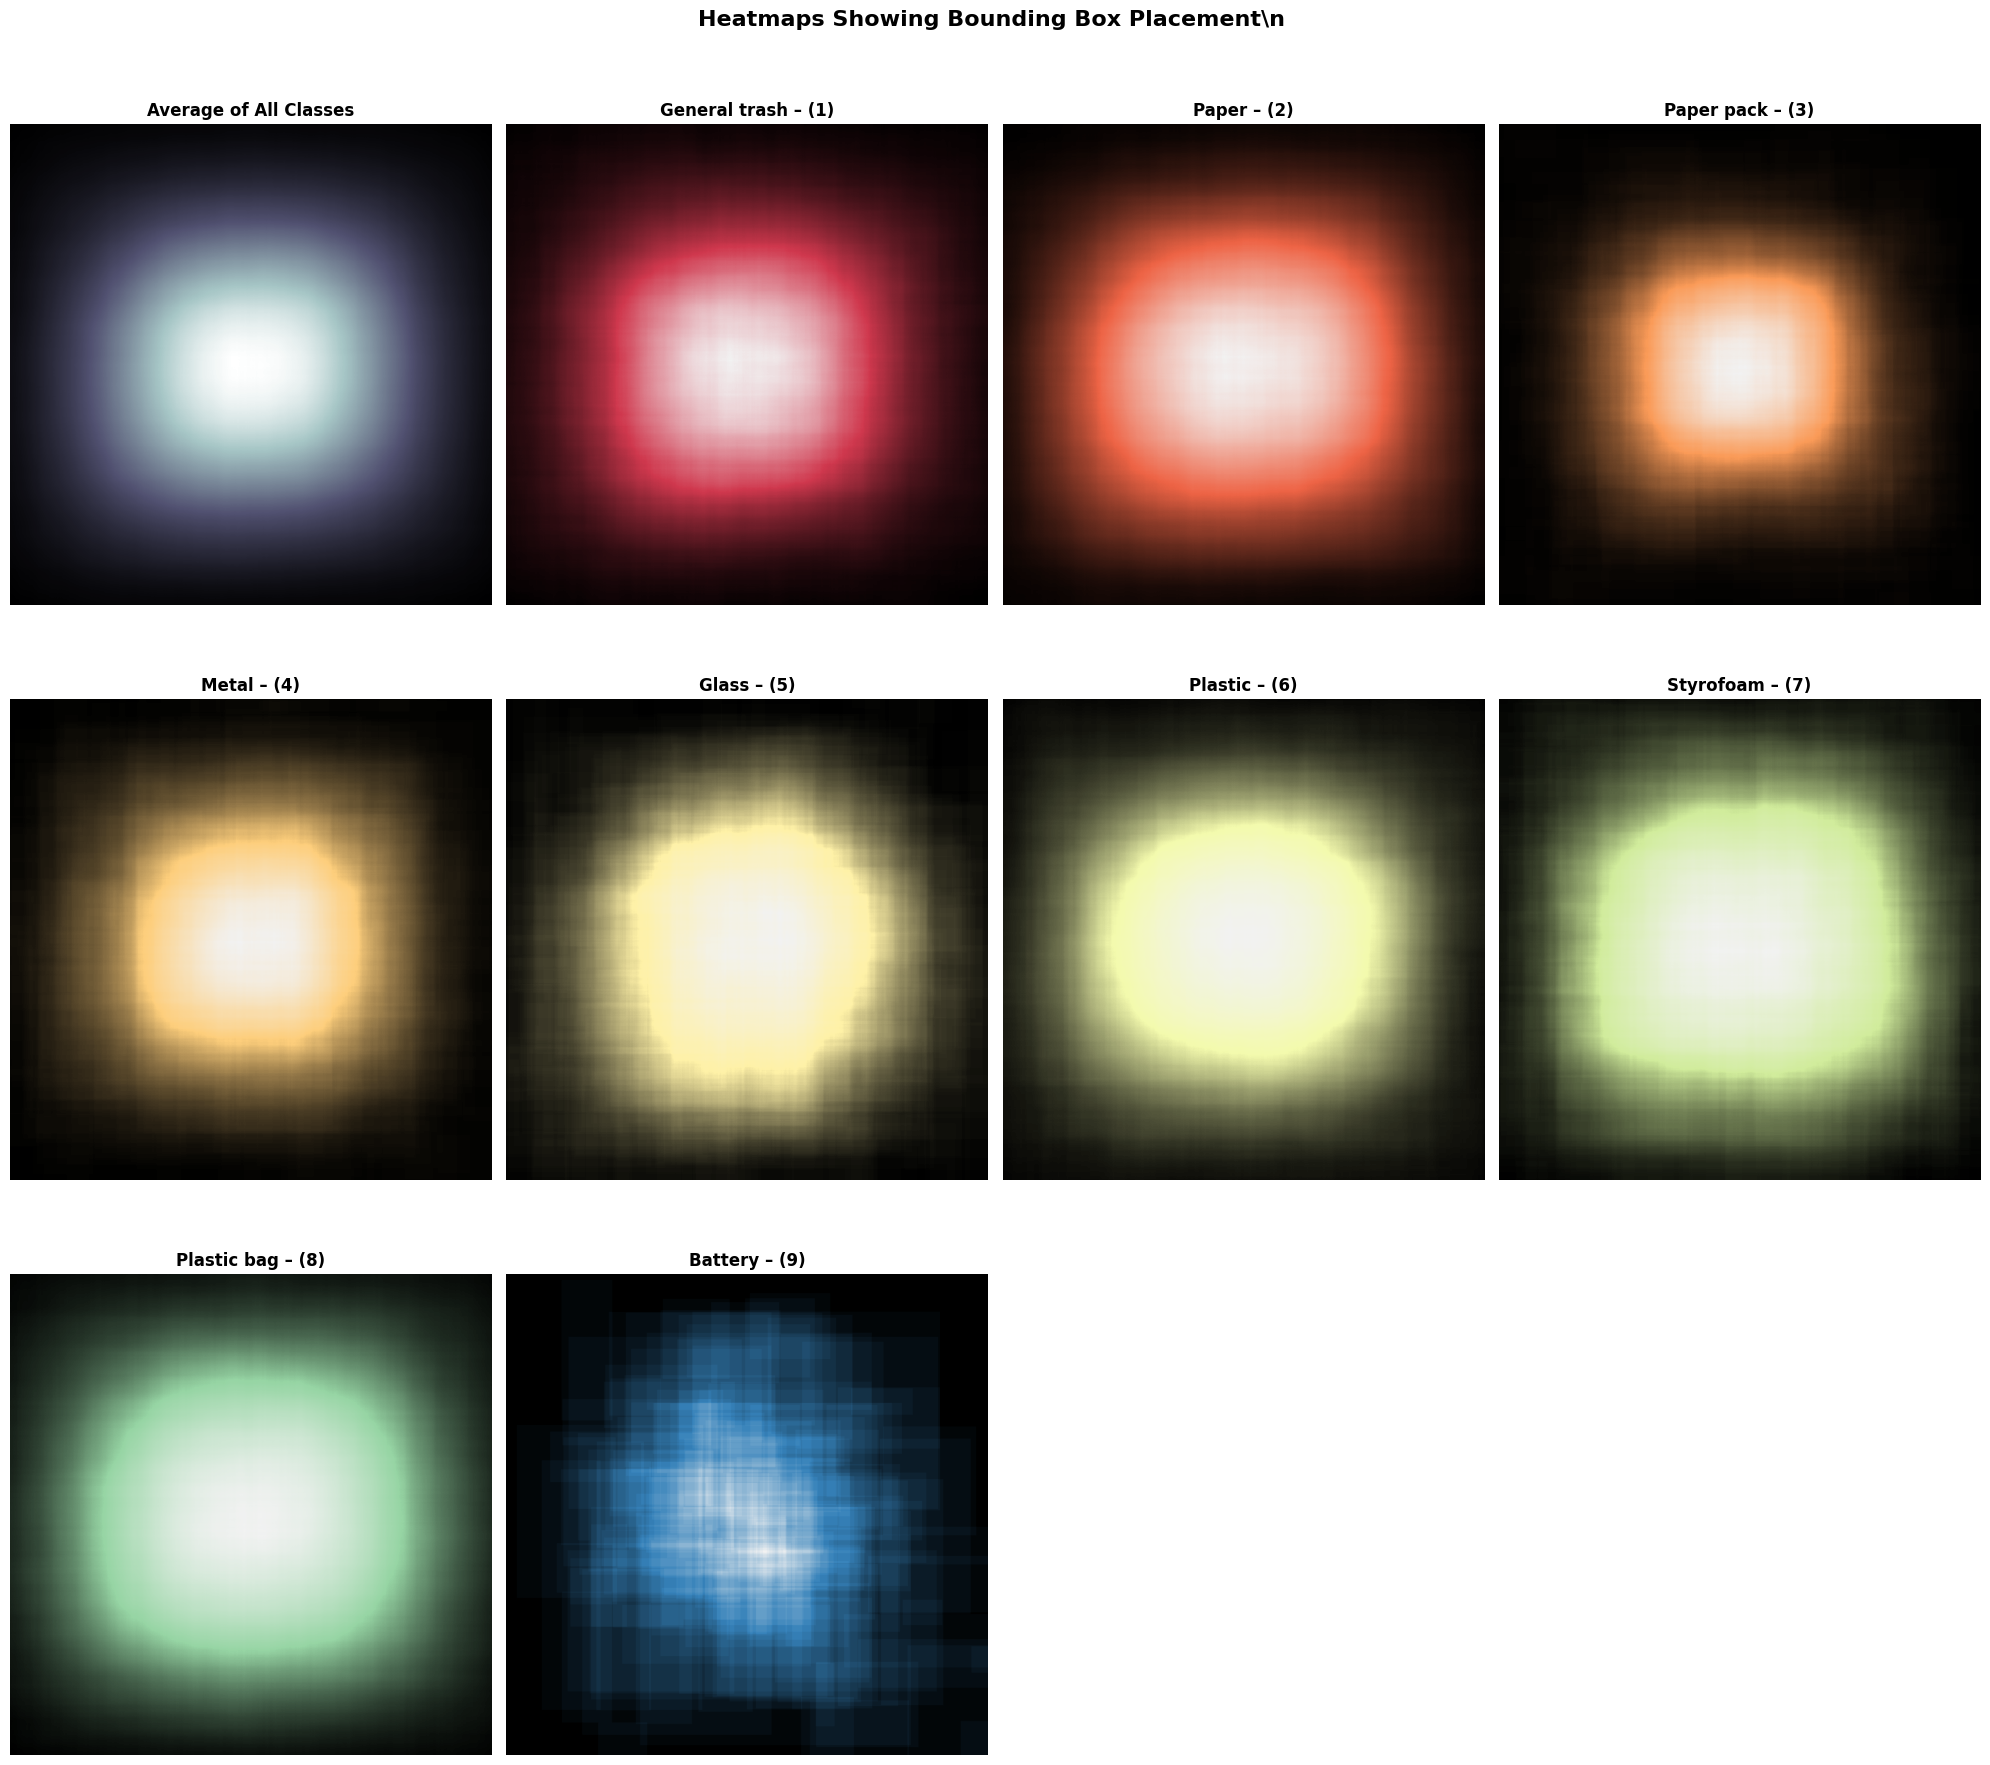

In [7]:
bbox_df = pd.DataFrame()
bbox_df['class_id'] = train_df['class_id'].values
bbox_df['class_name'] = train_df['class_name'].values
bbox_df['xmin'] = train_df['xmin'].values
bbox_df['xmax'] = train_df['xmax'].values
bbox_df['ymin'] = train_df['ymin'].values
bbox_df['ymax'] = train_df['ymax'].values
bbox_df['fracxmin'] = train_df['xmin'].values / 1024
bbox_df['fracxmax'] = train_df['xmax'].values / 1024
bbox_df['fracymin'] = train_df['ymin'].values / 1024
bbox_df['fracymax'] = train_df['ymax'].values / 1024
avesrcimg_height = 1024
avesrcimg_width = 1024

# DEFAULT

HEATMAP_SIZE = (avesrcimg_height, avesrcimg_width, 14)

# Initialize

heatmap = np.zeros((HEATMAP_SIZE), dtype=np.int16)
bboxnp = bbox_df[["class_id", "fracxmin", "fracxmax", "fracymin", "fracymax"]].to_numpy()
bboxnp[:, 1:3] *= avesrcimg_width
bboxnp[:, 3:5] *= avesrcimg_height
bboxnp = np.floor(bboxnp).astype(np.int16)

# Color map stuff

custom_cmaps = [
    matplotlib.colors.LinearSegmentedColormap.from_list(
        colors=[(0.,0.,0.), c, (0.95,0.95,0.95)],
        name=f"custom{i}") for i,c in enumerate(sns.color_palette("Spectral", 10))
]

custom_cmaps.pop(8) # Remove No-Finding

for row in tqdm(bboxnp, total=bboxnp.shape[0]):
    heatmap[row[3]:row[4]+1, row[1]:row[2]+1, row[0]] += 1

fig = plt.figure(figsize=(20,25))
plt.suptitle("Heatmaps Showing Bounding Box Placement\\n ", fontweight="bold", fontsize=16)

for i in range(10):
    plt.subplot(4, 4, i+1)
    if i==0:
        plt.imshow(heatmap.mean(axis=-1), cmap="bone")
        plt.title(f"Average of All Classes", fontweight="bold")

    else:
        plt.imshow(heatmap[:, :, i-1], cmap=custom_cmaps[i-1])
        plt.title(f"{classes[i-1]} – ({i})", fontweight="bold")

    plt.axis(False)

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

In [8]:
# Update bbox dataframe to make this easier

bbox_df["fracbboxarea"] = (bbox_df["fracxmax"]-bbox_df["fracxmin"])*(bbox_df["fracymax"]-bbox_df["fracymin"])

# bbox_df["classidasstr"] = bbox_df["classid"].map(classes)

display(bbox_df.head())

fig = px.box(bbox_df.sort_values(by="class_name"), x="class_name", y="fracbboxarea", color="class_name",
            color_discrete_sequence=LABELCOLORSWOUTNOFINDING, notched=True,
            labels={"classname":"Class Name", "fracbbox_area":"BBox Area (%)"},
            title="<b>DISTRIBUTION OF BBOX AREAS AS % OF SOURCE IMAGE AREA "
                "<i><sub>(Some Upper Outliers Excluded For Better Visualization)</sub></i></b>")

fig.update_layout(showlegend=True,
                yaxis_range=[-0.025,0.4],
                legend_title_text=None,
                xaxis_title="",
                yaxis_title="<b>Bounding Box Area %</b>",)

fig.show()

class_id     class_name   xmin   xmax   ymin   ymax  fracxmin  fracxmax  \
0         0  General trash  197.6  745.4  193.7  663.4  0.192969  0.727930   
1         3          Metal    0.0   57.6  407.4  588.0  0.000000  0.056250   
2         7    Plastic bag    0.0  144.6  455.6  637.2  0.000000  0.141211   
3         4          Glass  722.3  996.6  313.4  565.3  0.705371  0.973242   
4         5        Plastic  353.2  586.9  671.0  774.4  0.344922  0.573145   

   fracymin  fracymax  fracbboxarea  
0  0.189160  0.647852      0.245382  
1  0.397852  0.574219      0.009921  
2  0.444922  0.622266      0.025043  
3  0.306055  0.552051      0.065895  
4  0.655273  0.756250      0.023045

In [9]:
# Aspect Ratio is Calculated as Width/Height

bbox_df["aspectratio"] = (bbox_df["xmax"]-bbox_df["xmin"])/(bbox_df["ymax"]-bbox_df["ymin"])

# Display average means for each class_id so we can examine the newly created Aspect Ratio Column

display(bbox_df.groupby("class_name").mean())

# Generate the bar plot

fig = px.bar(x=sorted(classes), y=bbox_df.groupby("class_name").mean()["aspectratio"],
            color=sorted(classes), opacity=0.85,
            color_discrete_sequence=LABELCOLORSWOUTNOFINDING,
            labels={"x":"Class Name", "y":"Aspect Ratio (W/H)"},
            title="<b>Aspect Ratios For Bounding Boxes By Class</b>",)

fig.update_layout(
                yaxis_title="<b>Aspect Ratio (W/H)</b>",
                xaxis_title=None,
                legend_title_text=None)

fig.add_hline(y=1, line_width=2, line_dash="dot",
            annotation_font_size=10,
            annotation_text="<b>SQUARE ASPECT RATIO</b>",
            annotation_position="bottom left",
            annotation_font_color="black")

fig.add_hrect(y0=0, y1=0.5, line_width=0, fillcolor="red", opacity=0.125,
            annotation_text="<b>>2:1 VERTICAL RECTANGLE REGION</b>",
            annotation_position="bottom right",
            annotation_font_size=10,
            annotation_font_color="red")

fig.add_hrect(y0=2, y1=3.5, line_width=0, fillcolor="green", opacity=0.04,
            annotation_text="<b>>2:1 HORIZONTAL RECTANGLE REGION</b>",
            annotation_position="top right",
            annotation_font_size=10,
            annotation_font_color="green")

fig.show()

class_id        xmin        xmax        ymin        ymax  \
class_name                                                                
Battery               8  411.002516  639.876730  432.148428  647.143396   
Clothing              9  335.697222  730.380128  346.516026  738.193590   
General trash         0  392.753707  618.990923  404.283737  619.753833   
Glass                 4  410.682383  616.770265  398.284827  670.155703   
Metal                 3  396.325962  647.355235  377.684722  634.891774   
Paper                 1  384.916137  648.767191  384.417774  621.110941   
Paper pack            2  387.955741  632.852062  417.834671  637.919175   
Plastic               5  400.650357  640.025382  395.486035  626.166667   
Plastic bag           7  377.764175  653.141213  349.603109  650.812688   
Styrofoam             6  360.715439  659.862549  377.397150  629.704276   

               fracxmin  fracxmax  fracymin  fracymax  fracbboxarea  \
class_name                                                            
Battery        0.401370  0.624880  0.422020  0.631976      0.048075   
Clothing       0.327829  0.713262  0.338395  0.720892      0.180578   
General trash  0.383549  0.604483  0.394808  0.605228      0.075207   
Glass          0.401057  0.602315  0.388950  0.654449      0.066126   
Metal          0.387037  0.632183  0.368833  0.620011      0.087399   
Paper          0.375895  0.633562  0.375408  0.606554      0.087780   
Paper pack     0.378863  0.618020  0.408042  0.622968      0.072590   
Plastic        0.391260  0.625025  0.386217  0.611491      0.077239   
Plastic bag    0.368910  0.637833  0.341409  0.635559      0.105245   
Styrofoam      0.352261  0.644397  0.368552  0.614946      0.093069   

               aspectratio  
class_name                  
Battery           1.428327  
Clothing          1.228279  
General trash     1.433186  
Glass             1.043987  
Metal             1.239462  
Paper             1.391648  
Paper pack        1.296333  
Plastic           1.288092  
Plastic bag       1.106761  
Styrofoam         1.474087

In [10]:
bbox_df

class_id     class_name   xmin   xmax   ymin   ymax  fracxmin  \
0             0  General trash  197.6  745.4  193.7  663.4  0.192969   
1             3          Metal    0.0   57.6  407.4  588.0  0.000000   
2             7    Plastic bag    0.0  144.6  455.6  637.2  0.000000   
3             4          Glass  722.3  996.6  313.4  565.3  0.705371   
4             5        Plastic  353.2  586.9  671.0  774.4  0.344922   
...         ...            ...    ...    ...    ...    ...       ...   
23139         5        Plastic    0.0  944.1  116.2  930.3  0.000000   
23140         7    Plastic bag  302.1  567.3  439.3  655.4  0.295020   
23141         0  General trash  511.3  570.0  451.1  481.3  0.499316   
23142         1          Paper  255.0  526.7  421.4  616.5  0.249023   
23143         1          Paper  145.4  565.6  295.4  651.5  0.141992   

       fracxmax  fracymin  fracymax  fracbboxarea  aspectratio  
0      0.727930  0.189160  0.647852      0.245382     1.166276  
1      0.056250  0.397852  0.574219      0.009921     0.318937  
2      0.141211  0.444922  0.622266      0.025043     0.796256  
3      0.973242  0.306055  0.552051      0.065895     1.088924  
4      0.573145  0.655273  0.756250      0.023045     2.260155  
...         ...       ...       ...           ...          ...  
23139  0.921973  0.113477  0.908496      0.732986     1.159686  
23140  0.554004  0.429004  0.640039      0.054655     1.227210  
23141  0.556641  0.440527  0.470020      0.001691     1.943709  
23142  0.514355  0.411523  0.602051      0.050553     1.392619  
23143  0.552344  0.288477  0.636230      0.142701     1.180006  

[23144 rows x 12 columns]

In [11]:
bbox_area_mean = bbox_df.groupby('class_name').mean()["fracbboxarea"]

In [12]:
bbox_area_mean

class_name
Battery          0.048075
Clothing         0.180578
General trash    0.075207
Glass            0.066126
Metal            0.087399
Paper            0.087780
Paper pack       0.072590
Plastic          0.077239
Plastic bag      0.105245
Styrofoam        0.093069
Name: fracbboxarea, dtype: float64

-----------------------

In [13]:
train_oneclass = train_df[train_df["class_name"] == "Paper pack"]

In [14]:
img_iter = iter(train_oneclass["image_id"].unique())

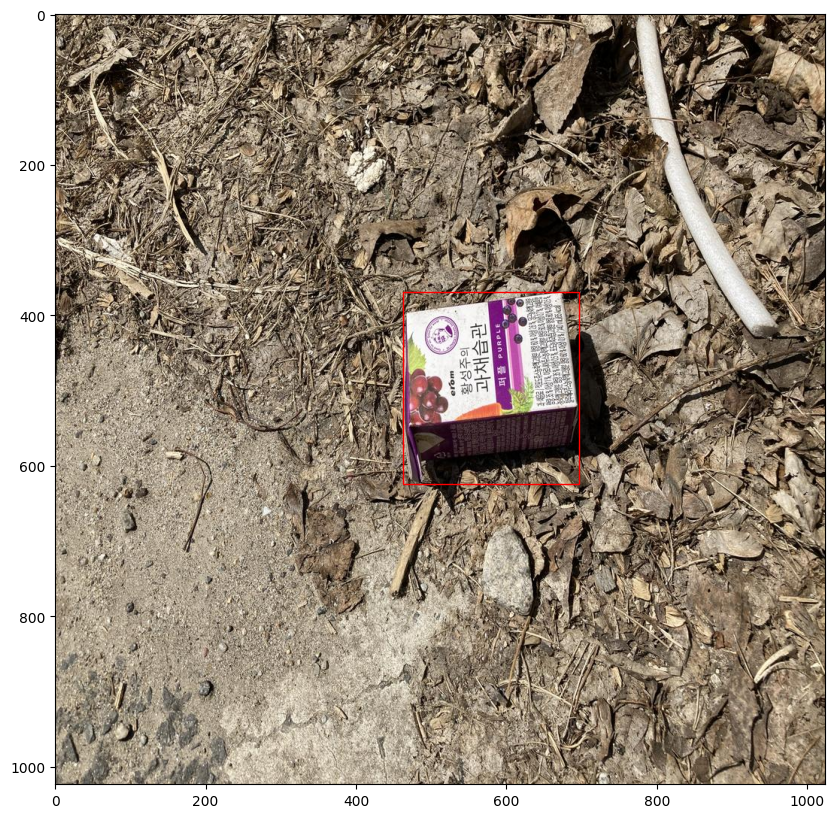

In [15]:
image_id = next(img_iter)
# img = Image.open(os.path.join('../../dataset', image_id))
img = cv2.imread(os.path.join('../../dataset', image_id))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots()
ax.imshow(img)
fig.set_figwidth(10)
fig.set_figheight(10)
for i, (_, _, _, *points) in train_oneclass[train_oneclass["image_id"] == image_id].iterrows():
    xmin, ymin, xmax, ymax = points
    ax.add_patch(patches.Rectangle(
        (xmin, ymin), xmax-xmin, ymax-ymin, edgecolor="red", facecolor="none"
    ))

--------------------

In [18]:
train_df

image_id     class_name  class_id   xmin   ymin   xmax   ymax
0      train/0000.jpg  General trash         0  197.6  193.7  745.4  663.4
1      train/0001.jpg          Metal         3    0.0  407.4   57.6  588.0
2      train/0001.jpg    Plastic bag         7    0.0  455.6  144.6  637.2
3      train/0001.jpg          Glass         4  722.3  313.4  996.6  565.3
4      train/0001.jpg        Plastic         5  353.2  671.0  586.9  774.4
...               ...            ...       ...    ...    ...    ...    ...
23139  train/4882.jpg        Plastic         5    0.0  116.2  944.1  930.3
23140  train/4882.jpg    Plastic bag         7  302.1  439.3  567.3  655.4
23141  train/4882.jpg  General trash         0  511.3  451.1  570.0  481.3
23142  train/4882.jpg          Paper         1  255.0  421.4  526.7  616.5
23143  train/4882.jpg          Paper         1  145.4  295.4  565.6  651.5

[23144 rows x 7 columns]

In [21]:
print(points)

[197.6, 193.7, 745.4, 663.4]


In [22]:
img_iter = iter(train_df["image_id"].unique())

train/0161.jpg


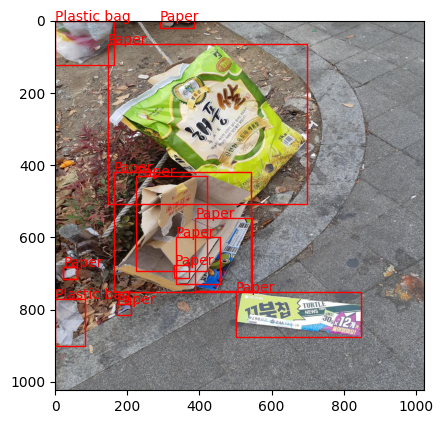

In [188]:
image_id = next(img_iter)
print(image_id)
# img = Image.open(os.path.join('../../dataset', image_id))
img = cv2.imread(os.path.join('../../dataset', image_id))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots()
ax.imshow(img)
# fig.set_figwidth(10)
# fig.set_figheight(10)
for i, (_, _, class_id, *points) in train_df[train_df["image_id"] == image_id].iterrows():
    xmin, ymin, xmax, ymax = points
    ax.add_patch(patches.Rectangle(
        (xmin, ymin), xmax-xmin, ymax-ymin, edgecolor="red", facecolor="none"
    ))
    ax.text(xmin, ymin, classes[class_id], color="red")
xmin, ymin, xmax, ymax = points
ax.add_patch(patches.Rectangle(
    (xmin, ymin), xmax-xmin, ymax-ymin, edgecolor="red", facecolor="none"
))

* 0010.jpg
  * ~~담배꽁초를 general trash로?~~
* 0015.jpg
  * 상단 위 물체 clothing?
* 0034.jpg
  * 플라스틱에 붙은 label general trash?
* 0054.jpg
  * 상자에 붙은 label general trash?
* 0055.jpg
  * outlier수준으로 헷갈림. paper와 구분?
* 0069.jpg
  * ~~담배꽁초~~, 왼쪽 아래 쓰레기
* 0085.jpg
  * 오른쪽 아래 작은 general trash 제거
  * 텀블러 plastic? metal?
* 0094.jpg
  * 작은 흰색 조각 general trash
* 0117.jpg
  * 작은 조각들 paper / general trash
* 0125.jpg
  * 봉투 안의 box나 플라스틱?
* 0129
  * 봉투 안의 general trash크기 맞추기
* 0141
  * 스티로폼 label안됨
* 
* clothing : 신발, 양말등
* general trash : 담뱃갑, 빨대
* plastic, glass 구별은 어떻게?
* 담배꽁초는 쓰레기로 분류하지 않음.
* 봉투 안에 들어간 쓰레기들은 분류하는 경우도 있고, 하지않는 경우도 있음.
  * 봉투에 가려진 쓰레기나 플라스틱 컵 안에 비치는 빨대 등은 분류하지 않고, 봉투 밖에 튀어나오거나 컵 밖에 튀어나온 빨대는 쓰레기로 분류?